What this code does:
1. For each day in the trace dataset calculate the amount of written data in terms of number of objects and number of bytes. 
2. Categorize the written data based on its size and compute how much of each size exists. 

In [4]:
import matplotlib
from matplotlib import rc
rc('text',usetex=True)
rc('text.latex', preamble=r'\usepackage{color}')


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import numpy as np
import math

import json
from os import listdir
from os.path import isfile, join
import sys
import glob
import graph_tool.all as gt
from datetime import datetime, date, time


statistics_dir = '/home/maniaa/ashes/dataset/statistics/'
stat_csv = [(statistics_dir + f) for f in listdir(statistics_dir) if (f.endswith(".csv") and isfile(join(statistics_dir, f)))]
stat_csv.sort()
stat_csv = stat_csv[1:]

In [140]:
pd.set_option("display.max_rows", 99)
pd.set_option('max_colwidth', 100)



intermediate_data = {}



def intermediate_data_collector(row, intermediate_data):
    if row['tmpouput'] not in intermediate_data:
        intermediate_data[row['tmpouput']] = {'size': row['HDFS_OUTPUT_SIZE'], 
                                  'id': len(intermediate_data), 'job': row['jobid'], 'overwrite': 0}
    intermediate_data[row['tmpouput']]['overwrite'] += 1
    
total_jobs_count = 0
total_hdfs_write = 0
total_hdfs_read = 0

for index, f in enumerate(stat_csv):
    print(f) # 6Am of each day
    month, day, year = f.split('/')[-1].split('.csv')[0].split('-')
    trace_starttime = datetime.combine(date(int(year), int(month), int(day)), time(7, 0))
    
    df = pd.read_csv(f)
    df = df[df['submitTime']/1000 > datetime.timestamp(trace_starttime)]
    df = df[df['state'] == 'SUCCEEDED']
    df['submit_ts'] = df['submitTime']//1000 - datetime.timestamp(trace_starttime);
    df['submit_10min'] = df['submit_ts']//(60); 
    df.sort_values('submit_ts', inplace=True)
    df.reset_index(inplace=True)
    total_jobs_count += len(df)
    total_hdfs_write += df['HDFS_OUTPUT_SIZE'].sum()
    total_hdfs_read += df['HDFS_INPUT_SIZE'].sum()
    
    df.apply(intermediate_data_collector, axis=1, args=[intermediate_data])
    
    if index == 0:
        break

/home/maniaa/ashes/dataset/statistics/08-02-2018.csv


In [75]:
print('Total jobs:', total_jobs_count, 'Total bytes written', round(total_hdfs_write/(1<<40), 2),
      'TB, Total bytes read', round(total_hdfs_read/(1<<50), 2), 'PB')

df2 = pd.DataFrame.from_dict(intermediate_data, orient='index').reset_index()
df2.columns = ['path', 'size', 'id', 'job', 'overwrite']

df_lt_1k = df2[df2['size'] < (1 << 10)]
total_writ_1k = (df_lt_1k['size']*df_lt_1k['overwrite']).sum()

df_lt_1m = df2[(df2['size'] >= (1 << 10)) & (df2['size'] < (1 << 20))]
total_writ_1m = (df_lt_1m['size']*df_lt_1m['overwrite']).sum()

df_lt_1g = df2[(df2['size'] >= (1 << 20)) & (df2['size'] < (1 << 30))]
total_writ_1g = (df_lt_1g['size']*df_lt_1g['overwrite']).sum()

df_lt_1t= df2[(df2['size'] >= (1 << 30)) & (df2['size'] < (1 << 40))]
total_writ_1t = (df_lt_1t['size']*df_lt_1t['overwrite']).sum()

df_gt_1t = df2[df2['size'] >= (1 << 40)]
total_writ_gt_1t = (df_gt_1t['size']*df_gt_1t['overwrite']).sum()

print('Total writes <1K:', round(total_writ_1k/(1 << 20), 2), 'MB, number of objects:', len(df_lt_1k), ', % of written objects:', round(100*len(df_lt_1k)/len(df2), 2),
     '\nTotal writes <1M:', round(total_writ_1m/(1 << 30), 2), 'GB, number of objects:', len(df_lt_1m), ', % of written objects:', round(100*len(df_lt_1m)/len(df2), 2),
     '\nTotal writes <1G:', round(total_writ_1g/(1 << 40), 2), 'TB, number of objects:', len(df_lt_1g), ', % of written objects:', round(100*len(df_lt_1g)/len(df2), 2),
     '\nTotal writes <1T:', round(total_writ_1t/(1 << 40), 2), 'TB, number of objects:', len(df_lt_1t), ', % of written objects:', round(100*len(df_lt_1t)/len(df2), 2),    
     '\nTotal writes >1T:', round(total_writ_gt_1t/(1 << 40), 2), 'TB, number of objects:', len(df_gt_1t), ', % of written objects:', round(100*len(df_gt_1t)/len(df2), 2))

df2

Total jobs: 398132 Total bytes written 540.39 TB, Total bytes read 11.39 PB
Total writes <1K: 7.87 MB, number of objects: 371108 , % of written objects: 96.46 
Total writes <1M: 1.26 GB, number of objects: 3652 , % of written objects: 0.95 
Total writes <1G: 1.59 TB, number of objects: 8011 , % of written objects: 2.08 
Total writes <1T: 191.21 TB, number of objects: 1873 , % of written objects: 0.49 
Total writes >1T: 349.99 TB, number of objects: 102 , % of written objects: 0.03


,path,size,id,job,overwrite
0,hdfs://datalake-nnha/tmp/hive/saia/721b7a99-a8cf-4b91-b054-1707d1b1502e/hive_2018-08-02_06-48-00...,5,0,job_1531656020138_226152,1
1,hdfs://datalake-nnha/tmp/hive/netappiq/2b49cb7f-dd18-4a5f-a48b-320cc1b64a9b/hive_2018-08-02_07-4...,17,1,job_1531656020138_226793,1
2,hdfs://datalake-nnha/tmp/hive/netappiq/035615b3-2e03-4724-b67a-86e87161e6ca/hive_2018-08-02_11-3...,17,2,job_1531656020138_229768,1
3,hdfs://datalake-nnha/tmp/hive/netappiq/99770f06-1605-4499-b230-a755a6771e73/hive_2018-08-02_10-1...,17,3,job_1531656020138_228769,1
4,hdfs://datalake-nnha/hive_external_tables/Users_db/guestdb/ubs_shelf_asups_sd/.hive-staging_hive...,52,4,job_1531656020138_229559,1
...,...,...,...,...,...
384741,hdfs://datalake-nnha/tmp/hive/netappiq/de08fa93-fbd1-4b51-a2fe-8a028e7fb04b/hive_2018-09-01_10-5...,17,384741,job_1534545750476_185906,1
384742,hdfs://datalake-nnha/hive_external_tables/Users_db/guestdb/ubs_shelf_asups_sd/.hive-staging_hive...,52,384742,job_1534545750476_183903,1
384743,hdfs://datalake-nnha/tmp/hive/saia/c2db68e7-f151-4729-ae80-fac18afd6362/hive_2018-09-01_04-59-10...,8,384743,job_1534545750476_180580,1
384744,hdfs://datalake-nnha/tmp/hive/netappiq/65fead4b-05a8-4802-b117-2968fd934d04/hive_2018-09-01_00-0...,17,384744,job_1534545750476_177777,1


Text(0, 0.5, 'Read ')

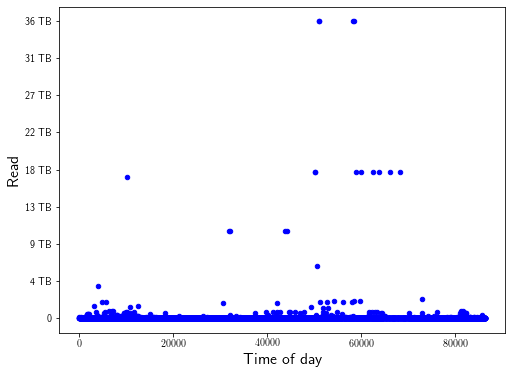

In [149]:
# for multiple 
def format_xticks10min(x, pos=None):
    hour = (int(x)*600)//3600
    daytime = ''
    if 0 <= hour and hour < 7:
        daytime = 'AM'
        hour += 7;
    elif hour == 7:
        daytime = 'PM'
        hour += 7;
    elif 7 < hour and hour < 19:
        daytime = 'PM'
        hour -= 5;
    elif hour == 19:
        daytime = 'AM'
        hour -= 5;
    elif 19 < hour and hour <= 24:
        daytime = 'AM'
        hour -= 17;
    return str(hour) + daytime


def format_ytickslog(y, pos=None):
    size = int(y)
    if size <= 0:
        return size;
    
    log = math.log2(size)
    if log < 10:
        return str(size) + ' B'
    if log >= 10 and log < 20:
        return str(int(2**(log - 10))) + ' KB'
    if log >= 20 and log < 30:
        return str(int(2**(log - 20))) + ' MB'
    if log >= 30 and log < 40:
        return str(int(2**(log - 30))) + ' GB'
    if log >= 40:
        return str(int(2**(log - 40))) + ' TB'
    return str(size)

dfg = df.groupby('submit_ts').agg({'HDFS_OUTPUT_SIZE': 'sum', 'HDFS_INPUT_SIZE': 'sum'}).reset_index()
dfg.columns = ['submitts', 'written', 'read']

fig, ax = plt.subplots(figsize= (8, 6))

#dfg.plot.scatter(x='submitts', y='written', ax=ax, color='green')
dfg.plot.scatter(x='submitts', y='read', ax=ax, color='blue')
#ax.set_yscale('log', basey=2)
#plt.xticks(np.arange(0, 146, 18), rotation=45)
#ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks10min))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_ytickslog))
plt.xlabel("Time of day", fontsize=16)
plt.ylabel("Read ", fontsize=16)



([<matplotlib.axis.XTick at 0x7f821f8b5e80>,
 <a list of 8 Text xticklabel objects>)

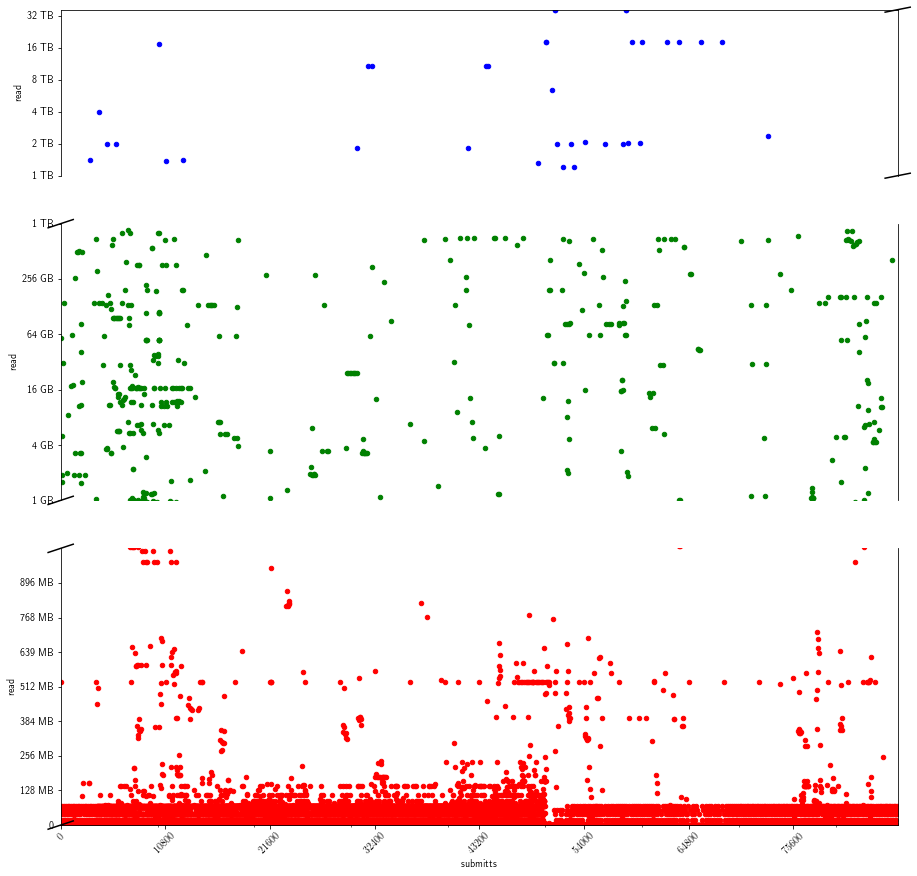

In [193]:
dfg = df.groupby('submit_ts').agg({'HDFS_OUTPUT_SIZE': 'sum', 'HDFS_INPUT_SIZE': 'sum'}).reset_index()
dfg.columns = ['submitts', 'written', 'read']


colors = ['#80b1d3', '#b3de69', '#fdb462', '#fc8d62', '#e41a1c','#252525']
fig, (ax, ax2, ax3) = plt.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [3, 5, 5]}, figsize=(15,15))

dfg.plot.scatter(x='submitts', y='read', ax=ax, color='blue')
dfg.plot.scatter(x='submitts', y='read', ax=ax2, color='green')
dfg.plot.scatter(x='submitts', y='read', ax=ax3, color='red')

ax.set_ylim((1<<40), dfg['read'].max())
ax.set_yscale('log', basey=2)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_ytickslog))
ax.spines['bottom'].set_visible(False)
#ax.xaxis.tick_bottom()
ax.tick_params(which='both', bottom=False)

ax2.set_ylim((1<<30), (1<<40)-1)
ax2.set_yscale('log', basey=2)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_ytickslog))
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.tick_params(which='both', bottom=False)

ax3.set_ylim(0, (1<<30)-1)
ax3.set_yticks(np.arange(0, (1<<30), (1<<27)))
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(format_ytickslog))
ax3.spines['top'].set_visible(False)

d = .015 
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)

kwargs.update(transform=ax3.transAxes)  # switch to the bottom axes
ax3.plot((-d,+d), (1-d,1+d), **kwargs)
ax3.plot((-d,+d), (-d,+d), **kwargs)


#dfg.plot.scatter(x='submitts', y='written', ax=ax, color='green')

#ax.set_yscale('log', basey=2)
plt.xlim(0,dfg['submitts'].max()+10)
plt.xticks(np.arange(0, dfg['submitts'].max(), 10800), rotation=45)
#ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks10min))

#plt.xlabel("Time of day", fontsize=16)
#plt.ylabel("Read ", fontsize=16)


In [153]:
(39950413013211 >> 40)

36

1. How much time is used by jobs with large intermediate data?
2. Does small jobs waits for the large jobs to finish?
3. Do we have local HDFS on this cluster?
4. What is the age of each dataset when it is first accessed?
5. 

In [200]:
df[df['HDFS_INPUT_SIZE'] > (1<<40)]['runTime'].sum()//(3600*1000)

28

In [196]:
len(df[df['HDFS_OUTPUT_SIZE'] > (1<<40)])

3